### Denoising Autoencoders And Where To Find Them (10 pts)

Today we're going to train deep autoencoders and deploy them to faces and search for similar images.

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

In [1]:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall20/week08_generative/lfw_dataset.py -O lfw_dataset.py
!pip install Image Pillow==5.1.0 scipy==1.1.0

--2021-11-22 19:25:07--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall20/week08_generative/lfw_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3056 (3.0K) [text/plain]
Saving to: ‘lfw_dataset.py’

lfw_dataset.py      100%[===================>]   2.98K  --.-KB/s    in 0s      

2021-11-22 19:25:07 (33.3 MB/s) - ‘lfw_dataset.py’ saved [3056/3056]



In [2]:
import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

LATENT_DIMENSION = 4

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.set_default_tensor_type(torch.cuda.DoubleTensor) # uses cuda floats by default

num_workers = 4 if device.type=='cuda' else 0

print(device)

cuda


In [4]:
import numpy as np
from lfw_dataset import fetch_lfw_dataset
from sklearn.model_selection import train_test_split

X, attr = fetch_lfw_dataset(use_raw=True, dimx=38, dimy=38)
X = X.transpose([0, 3, 1, 2]).astype('float32') / 256.0

img_shape = X.shape[1:]

X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [5]:
X_train_tensor = torch.from_numpy(X_train).type(torch.DoubleTensor)
X_test_tensor = torch.Tensor(X_test).type(torch.DoubleTensor)

In [6]:
print(img_shape)

(3, 38, 38)


In [7]:
attr.head()

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.56835,-1.88904,1.7372,-0.929729,-1.4718,-0.19558,-0.835609,-0.351468,-1.01253,-0.719593,-0.632401,0.464839,-0.973528,1.56519,-1.2967,-1.54272,-0.684671,-0.86499,0.766886,-0.218952,-1.65567,-0.787044,-0.599665,0.458519,0.18976,0.851555,-0.38572,-0.497719,-0.161149,-0.257514,-0.0888388,0.455469,-0.839211,-0.0229481,-0.922568,-0.114539,1.46122,1.75848,0.0688935,1.26786,-1.12024,0.917617,-1.30796,-1.50041,1.02922,0.832363,-0.498657,0.251365,-0.705281,-0.515715,0.374239,-0.168675,-0.614143,3.0977,1.52386,0.779278,-0.0714539,-1.24648,-0.769283,-0.725597,-1.82061,-2.07298,-0.960759,0.361738,1.16612,-1.16492,-1.13999,-2.37175,-1.29993,-0.414682,-1.1449,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.28218,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,-0.736883,0.294554,-1.27765,0.954771,-0.990992,-1.16736,-0.835146,0.798544,-0.971679,0.342826,-1.32256,0.962937,-1.19936,-0.157307,0.443224,-0.00288156,-0.0211584,-0.226563,-0.0810386,-0.827202,-0.106624,1.22759,-0.812223,-1.24126,0.0962725,-0.404544,0.325919,0.474452,1.13536,0.0587247,0.611176,-1.17251,0.428512,-0.874235,-1.19156,0.192359,-0.204166,0.342347,0.239512,-1.47469,0.236057,-0.565208,-0.712542,2.99708,-0.273306,-0.187722,-0.604608,-1.3217,-0.938559,0.494294,-0.659043,-1.14375,-0.775722,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.00624408,-0.0304057,-0.480128,0.66676,-0.496559
2,0.997749,-1.36419,-0.157377,-0.756447,-1.89183,-0.871526,-0.862893,0.0314447,-1.34152,-0.0900375,-1.20073,-0.33246,-0.537006,1.29836,-1.49847,-1.28582,1.14174,0.172817,0.106412,-0.788843,0.349295,-1.64372,0.454287,1.18946,-0.688414,-0.590574,-0.266673,0.467224,0.567348,-1.7191,0.124667,1.60274,-0.659399,-1.75376,1.20447,0.0221884,-1.13544,1.70286,-0.422144,0.587859,0.414363,0.344447,-1.26045,-0.577746,0.405567,-1.91655,0.92126,0.247437,-0.428451,-0.772273,0.370673,-0.509596,-0.768482,1.7069,0.126524,-0.497001,-0.393042,-0.178307,-1.18023,-0.596914,-1.80538,-0.951643,-0.838087,1.54974,1.88475,-0.999765,-1.35986,-1.91211,-1.09563,0.915126,-0.572332,0.144262,-0.841231
3,1.12272,-1.9978,1.91614,-2.51421,-2.58007,-1.40424,0.0575511,0.000195882,-1.27351,-1.43146,-0.0705188,-0.339239,-2.00415,0.665695,-0.77594,-1.47163,-1.17908,0.563327,-0.664429,-1.40793,0.435594,-0.589988,-1.6035,1.17074,0.760103,0.211498,-0.51618,-1.33115,0.20284,0.149645,-0.0464296,0.640885,-0.107616,-0.831271,-0.827005,-0.588725,0.429255,1.58766,0.499086,-0.0568692,-0.866643,-0.959689,0.35073,-1.33535,-0.42789,0.826817,-0.256779,0.149751,-1.20153,-1.08392,0.255363,-0.650423,-0.506293,1.10159,0.640783,1.57503,-0.484397,-1.55968,-1.43712,0.379363,-0.648233,-2.25735,-1.07561,0.567822,-0.176089,1.10812,-1.60094,-3.26461,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.07821,-2.0081,1.67621,-2.27806,-2.65185,-1.34841,0.649089,0.0176564,-1.88911,-1.85721,-0.568057,0.840375,-1.98127,1.66671,-0.910723,-1.99351,-0.871335,0.507786,-0.488947,-0.88649,-0.990132,-0.750813,-0.378479,0.583086,-1.4796,0.250185,-0.381123,-0.611991,-0.143091,-1.07276,0.432094,1.08919,-0.470929,-1.17712,-0.111313,-0.154603,-1.03151,2.39246,-0.191576,1.2279,-1.3818,-1.52885,0.907964,-1.32429,-0

X shape: (13143, 3, 38, 38)
attr shape: (13143, 73)


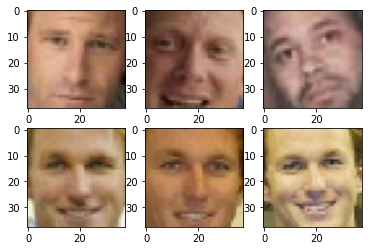

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i].transpose([1,2,0]))

print("X shape:", X.shape)
print("attr shape:", attr.shape)

### Autoencoder architecture

Let's design autoencoder as a single network, going from input image through bottleneck into the reconstructed image.

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



## First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [9]:
class Reshape(nn.Module):
    """ this class corresponds to torch.reshape function and may be used as a reshape layer """
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
    def forward(self, input):
        return input.reshape(*self.shape)

In [10]:
class PCAAutoencoder(nn.Module):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    def __init__(self, code_size=50):
        super(PCAAutoencoder, self).__init__()
        self.enc = nn.Sequential(Reshape(-1, np.prod(img_shape)), nn.Linear(np.prod(img_shape), code_size))
        self.dec = nn.Sequential(nn.Linear(code_size, np.prod(img_shape)), Reshape(-1, img_shape[0], img_shape[1], img_shape[2])) 
    
    def batch_loss(self, batch, reference):
        reconstruction = self.dec(self.enc(batch))
        return torch.mean((reference - reconstruction) ** 2)

### Train the model

As usual, iterate minibatches of data and call train_step, then evaluate loss on validation data.

__Note to py2 users:__ you can safely drop `flush=True` from any code below.

In [11]:
from tqdm import tqdm

def train(model, dataset, dataset_test, num_epoch=32, gd=None, noise_function=None, noise_function_params=None):
    model.to(device)
    model.double()
    
    if gd is None:
        gd = optim.Adamax(model.parameters(), lr=0.002)
    if noise_function_params is None:
        noise_function_params = {}

    dataloader = DataLoader(dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=num_workers,
                            generator=torch.Generator(device=device))
    
    dataloader_test = DataLoader(dataset_test,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True,
                                 num_workers=num_workers,
                                 generator=torch.Generator(device=device))

    losses = []
    scores = []

    for epoch in range(num_epoch):
        model.train(True)
        for i, (batch) in tqdm(enumerate(dataloader)):
            gd.zero_grad()
            if noise_function is not None:
                batch_noised = noise_function(batch, **noise_function_params).to(device)
                loss = model.batch_loss(batch_noised, batch.to(device))
            else:
                batch = batch.to(device)
                loss = model.batch_loss(batch, batch)
            (loss).backward()
            losses.append(loss.data.cpu().numpy())
            gd.step()
            gd.zero_grad()
        train_mse = np.mean(losses[-(i+1):])
        
        model.train(False)
        for i, (batch) in enumerate(dataloader_test):
            batch = batch.to(device=device)
            scores.append(model.batch_loss(batch, batch).data.cpu().numpy())
        test_mse  = np.mean(scores[-(i+1):])

        print(f"{epoch+1}, Train loss: {train_mse}, Test loss: {test_mse}")

In [12]:
def visualize(img, model):
    """Draws original, encoded and decoded images"""
    model.train(False)
    code = model.enc(img[None].cuda(device=device))

    reco = model.dec(code)

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img.cpu().numpy().transpose([1, 2, 0]).clip(0, 1))

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.cpu().detach().numpy().reshape([code.shape[-1] // 2, -1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco[0].cpu().detach().numpy().transpose([1, 2, 0]).clip(0, 1))
    plt.show()

In [13]:
aenc = PCAAutoencoder()
train(aenc, X_train_tensor, X_test_tensor, 40)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
370it [00:01, 185.72it/s]


1, Train loss: 0.10108492628723484, Test loss: 0.02409364533030138


370it [00:01, 195.47it/s]


2, Train loss: 0.023209859807182917, Test loss: 0.02331609074173279


370it [00:01, 197.81it/s]


3, Train loss: 0.02288905898039472, Test loss: 0.022938637338818894


370it [00:01, 201.17it/s]


4, Train loss: 0.02264494575742403, Test loss: 0.022899520305891145


370it [00:01, 197.12it/s]


5, Train loss: 0.022344731595808083, Test loss: 0.022358687466926645


370it [00:01, 198.26it/s]


6, Train loss: 0.02183376670080863, Test loss: 0.021520859286671013


370it [00:01, 204.06it/s]


7, Train loss: 0.020824070673985614, Test loss: 0.020347798233371874


370it [00:01, 201.37it/s]


8, Train loss: 0.01926329166774687, Test loss: 0.018654504418624922


370it [00:01, 200.61it/s]


9, Train loss: 0.017640076716133695, Test loss: 0.017743405067903485


370it [00:01, 199.28it/s]


10, Train loss: 0.01629821942172528, Test loss: 0.01620233932158788


370it [00:01, 198.88it/s]


11, Train loss: 0.015007774441450976, Test loss: 0.014371346135913602


370it [00:01, 203.81it/s]


12, Train loss: 0.01376034690417465, Test loss: 0.013287819715837543


370it [00:01, 199.77it/s]


13, Train loss: 0.012600431543697001, Test loss: 0.012146580054536829


370it [00:01, 200.12it/s]


14, Train loss: 0.011646422293195447, Test loss: 0.011601451384284889


370it [00:01, 201.81it/s]


15, Train loss: 0.010825280969542979, Test loss: 0.010364023964588335


370it [00:01, 199.91it/s]


16, Train loss: 0.010035602332637047, Test loss: 0.009945034967397163


370it [00:01, 198.49it/s]


17, Train loss: 0.009615797307149794, Test loss: 0.009242414021022285


370it [00:01, 203.50it/s]


18, Train loss: 0.009070592882837954, Test loss: 0.00887219055875189


370it [00:01, 202.99it/s]


19, Train loss: 0.008826702036465552, Test loss: 0.008818449110658474


370it [00:01, 203.55it/s]


20, Train loss: 0.008383406609918292, Test loss: 0.008108982807464924


370it [00:01, 206.37it/s]


21, Train loss: 0.008003311600045446, Test loss: 0.007846608408611058


370it [00:01, 197.29it/s]


22, Train loss: 0.00765796877135138, Test loss: 0.007662139076119391


370it [00:01, 199.46it/s]


23, Train loss: 0.0075438187730225235, Test loss: 0.00785350842086408


370it [00:01, 201.93it/s]


24, Train loss: 0.007366635867355175, Test loss: 0.007784372869347268


370it [00:01, 200.83it/s]


25, Train loss: 0.007196121504638302, Test loss: 0.0068751374241928665


370it [00:01, 196.71it/s]


26, Train loss: 0.006848134630640598, Test loss: 0.007254807574612299


370it [00:01, 196.41it/s]


27, Train loss: 0.006829853475621278, Test loss: 0.0067285512074071315


370it [00:01, 201.55it/s]


28, Train loss: 0.006701183952803513, Test loss: 0.006842413457403887


370it [00:01, 197.84it/s]


29, Train loss: 0.006559785413014791, Test loss: 0.006588521949159489


370it [00:01, 194.93it/s]


30, Train loss: 0.00653235319421581, Test loss: 0.006524295192677103


370it [00:01, 195.74it/s]


31, Train loss: 0.0064413581863754805, Test loss: 0.006531741968194747


370it [00:01, 198.57it/s]


32, Train loss: 0.0063097931528430075, Test loss: 0.006347222778750247


370it [00:01, 201.41it/s]


33, Train loss: 0.006299447804767718, Test loss: 0.006273543180955575


370it [00:01, 195.38it/s]


34, Train loss: 0.006290479127433001, Test loss: 0.006291432015662417


370it [00:01, 198.35it/s]


35, Train loss: 0.006156460930436305, Test loss: 0.006244376712100887


370it [00:01, 194.55it/s]


36, Train loss: 0.006140088330707488, Test loss: 0.006243640285404864


370it [00:01, 197.27it/s]


37, Train loss: 0.0061412668024139585, Test loss: 0.0063739043788966065


370it [00:01, 200.18it/s]


38, Train loss: 0.0060243928722737, Test loss: 0.0061896300957527475


370it [00:01, 197.35it/s]


39, Train loss: 0.005992247132014266, Test loss: 0.006964795351986216


370it [00:01, 199.46it/s]


40, Train loss: 0.005939629728008525, Test loss: 0.0059953131096768105


In [14]:
dataloader_test = DataLoader(X_test_tensor,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=num_workers,
                             generator=torch.Generator(device=device))
scores = []

for i, (batch) in enumerate(dataloader_test):
    batch = batch.to(device=device)
    scores.append(aenc.batch_loss(batch, batch).data.cpu().numpy())
print(np.mean(scores))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.006006796684806732


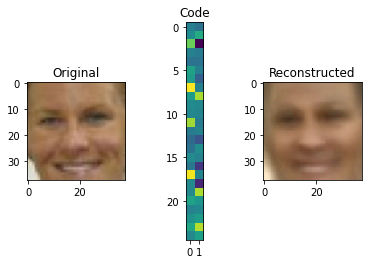

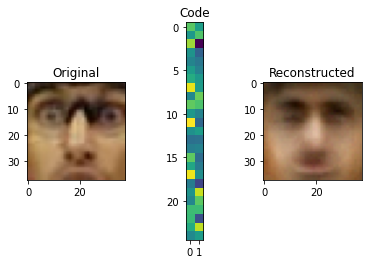

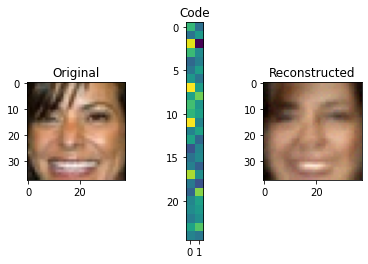

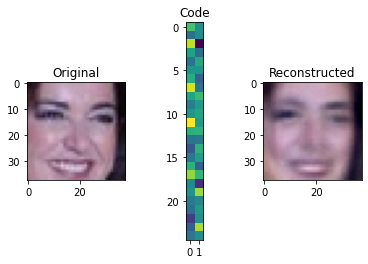

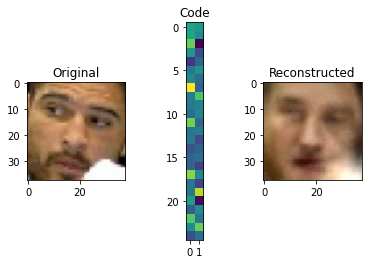

In [15]:
for i in range(5):
    img = X_test_tensor[i]
    visualize(img, aenc)

### Going deeper

PCA is neat but surely we can do better. This time we want you to build a deep autoencoder by... stacking more layers.

In particular, your encoder and decoder should be at least 3 layers deep each. You can use any nonlinearity you want and any number of hidden units in non-bottleneck layers provided you can actually afford training it.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

A few sanity checks:
* There shouldn't be any hidden layer smaller than bottleneck (encoder output).
* Don't forget to insert nonlinearities between intermediate dense layers.
* Convolutional layers are allowed but not required. To undo convolution use L.Deconv2D, pooling - L.UpSampling2D.
* Adding activation after bottleneck is allowed, but not strictly necessary.

### Convolutional Autoencoder

In [20]:
class ConvBlock(nn.Module):
    """
    Convolutional block with optional pooling, batch norm and dropout
    """
    def __init__(self, in_dim, out_dim, kernel_size, padding, activation, dropout, batch_norm, pool=None, pool_kernel_size=2):
        super().__init__()
        self.in_channels = in_dim
        self.pool = pool
        self.out_channels = out_dim
        self.batch_norm = batch_norm
        self.batch_norm_2d = nn.BatchNorm2d(out_dim)
        self.activation = activation
        self.dropout = nn.Dropout(dropout)

        
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size=kernel_size, padding=padding)

        if pool == 'max':
            self.pool = nn.MaxPool2d(pool_kernel_size, 2)
        elif pool == 'mean':
            self.pool = nn.AvgPool2d(pool_kernel_size, 2)
        elif pool is None:
            self.pool = pool
        else:
            raise NotImplementedError

    def forward(self, x):
        x = self.conv(x)
        if self.pool:
            x = self.pool(x)
        if self.batch_norm:
            x = self.batch_norm_2d(x)
        if self.activation:
            x = self.activation(x)
        x = self.dropout(x)
        return x

In [21]:
class DeConvBlock(nn.Module):
    """
    De-convolutional block with upsamplig, optional batch norm and dropout
    """
    def __init__(self, in_dim, out_dim, kernel_size, padding, activation, dropout, batch_norm, upsample=None, upscale_size=None):
        super().__init__()
        self.in_channels = in_dim
        self.out_channels = out_dim
        self.batch_norm = batch_norm
        self.batch_norm_2d = nn.BatchNorm2d(out_dim)
        self.activation = activation
        self.dropout = nn.Dropout(dropout)
        self.upscale_size = upscale_size
        self.upsample = nn.Upsample(size=upscale_size)

        self.deconv = nn.ConvTranspose2d(in_dim, out_dim, kernel_size, padding=padding)


    def forward(self, x):
        if self.upscale_size:
            x = self.upsample(x)

        x = self.deconv(x)

        if self.batch_norm:
            x = self.batch_norm_2d(x)
        if self.activation:
            x = self.activation(x)
        x = self.dropout(x)
        return x

In [22]:
class DeepAutoencoder(nn.Module):
    def __init__(self, code_size=50, dropout=0.05):
        super(DeepAutoencoder, self).__init__()

        activation = torch.nn.functional.relu
        batch_norm = True

        img_shape_prod = 1024

        # encoder
        # [-1, 3, 38, 38]
        # [-1, 16, 19, 19]
        # [-1, 32, 9, 9]
        # [-1, 64, 4, 4]
        # [-1, 1024]
        # [-1, 50]

        self.enc = nn.Sequential(
            ConvBlock(3, 16, 3, 1, activation, dropout, batch_norm, 'max'),
            ConvBlock(16, 32, 3, 1, activation, dropout, batch_norm, 'max', pool_kernel_size=3),
            ConvBlock(32, 64, 3, 1, activation, dropout, batch_norm, 'max', pool_kernel_size=3),
            Reshape(-1, img_shape_prod),
            nn.Linear(img_shape_prod, code_size)
        )

        self.dec = nn.Sequential(
            nn.Linear(code_size, img_shape_prod),
            Reshape(-1, 64, 4, 4),
            DeConvBlock(64, 32, 3, 1, activation, dropout, batch_norm, upscale_size=(9, 9)),
            DeConvBlock(32, 16, 3, 1, activation, dropout, batch_norm, upscale_size=(19, 19)),
            DeConvBlock(16, 3, 3, 1, activation, dropout, batch_norm, upscale_size=(38, 38))
        )
    
    def batch_loss(self, batch, reference):
        reconstruction = self.dec(self.enc(batch))
        return torch.mean((reference - reconstruction)**2)

In [113]:
model_test = DeepAutoencoder().to(device)

In [23]:
#Check autoencoder shapes along different code_sizes

def check_shapes(model_class):
    get_dim = lambda layer: np.prod(layer.output_shape[1:])
    for code_size in [1,8,32,128,512,1024]:
        help_tensor = next(iter(DataLoader(X_train_tensor, batch_size=BATCH_SIZE)))
        model = model_class(code_size).to(device)
        encoder_out = model.enc(help_tensor.cuda(device))
        decoder_out = model.dec(encoder_out)
        print("Testing code size %i" % code_size)

        assert encoder_out.shape[1:] == torch.Size([code_size]),"encoder must output a code of required size"
        assert decoder_out.shape[1:] == img_shape,   "decoder must output an image of valid shape"

        assert (sum([1 + len(list(c1level.children())) for c1level in model.dec.children()]) >= 6),  "decoder must contain at least 3 dense layers"

        del encoder_out
        del decoder_out
        torch.cuda.empty_cache()
    print("All tests passed!")

In [ ]:
check_shapes(DeepAutoencoder)

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
Testing code size 1024
All tests passed!


__Hint:__ if you're getting "Encoder layer is smaller than bottleneck" error, use code_size when defining intermediate layers. 

For example, such layer may have code_size*2 units.

In [ ]:
aenc_deep = DeepAutoencoder()
train(aenc_deep, X_train_tensor, X_test_tensor, num_epoch=50)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
370it [00:08, 42.51it/s]


1, Train loss: 0.06849892372631611, Test loss: 0.028336659024138844


370it [00:08, 44.43it/s]


2, Train loss: 0.037052408684836106, Test loss: 0.01728305139539666


370it [00:08, 45.58it/s]


3, Train loss: 0.030628285469184655, Test loss: 0.014439443901528206


370it [00:08, 46.17it/s]


4, Train loss: 0.028331545125355056, Test loss: 0.013592171583001786


370it [00:07, 46.46it/s]


5, Train loss: 0.02715086424748342, Test loss: 0.012124454616266222


370it [00:07, 46.57it/s]


6, Train loss: 0.026102043237369005, Test loss: 0.011653823542956234


370it [00:07, 46.35it/s]


7, Train loss: 0.025490825034840618, Test loss: 0.011064749346302239


370it [00:07, 47.30it/s]


8, Train loss: 0.024937916180375986, Test loss: 0.010961275719777085


370it [00:07, 46.65it/s]


9, Train loss: 0.024412459220764966, Test loss: 0.010326166832248782


370it [00:07, 46.34it/s]


10, Train loss: 0.024040829471554313, Test loss: 0.009953471576075392


370it [00:08, 46.01it/s]


11, Train loss: 0.023717579205399103, Test loss: 0.009892172777462488


370it [00:07, 46.64it/s]


12, Train loss: 0.023592075474131582, Test loss: 0.009531867861418363


370it [00:07, 46.87it/s]


13, Train loss: 0.023168751977801848, Test loss: 0.009246023678370525


370it [00:07, 46.45it/s]


14, Train loss: 0.023064349077207568, Test loss: 0.008761010082108256


370it [00:07, 46.57it/s]


15, Train loss: 0.022947622308688912, Test loss: 0.009333991366708358


370it [00:08, 46.09it/s]


16, Train loss: 0.022738838596966536, Test loss: 0.008846264348362195


370it [00:07, 46.66it/s]


17, Train loss: 0.022684155709879108, Test loss: 0.00835801054693583


370it [00:07, 46.54it/s]


18, Train loss: 0.022583682270937707, Test loss: 0.00859921635939145


370it [00:08, 46.06it/s]


19, Train loss: 0.022444257436733492, Test loss: 0.00826303281788943


370it [00:07, 46.28it/s]


20, Train loss: 0.02236670125056785, Test loss: 0.008547011814630837


370it [00:08, 45.82it/s]


21, Train loss: 0.022309976877087665, Test loss: 0.008537291135215634


370it [00:07, 46.60it/s]


22, Train loss: 0.022301349693342125, Test loss: 0.008099954737966576


370it [00:08, 46.08it/s]


23, Train loss: 0.022223339237022587, Test loss: 0.008140492594112935


370it [00:08, 46.10it/s]


24, Train loss: 0.02205803734449554, Test loss: 0.008485848779618825


370it [00:08, 46.13it/s]


25, Train loss: 0.022041000375927215, Test loss: 0.007990297159394623


370it [00:07, 46.81it/s]


26, Train loss: 0.02203024213147882, Test loss: 0.00809083490568576


370it [00:07, 46.52it/s]


27, Train loss: 0.021972221795134653, Test loss: 0.008491317751882796


370it [00:08, 45.48it/s]


28, Train loss: 0.021893798981506726, Test loss: 0.00802820755467579


370it [00:08, 46.17it/s]


29, Train loss: 0.021853308995773993, Test loss: 0.008225028501017818


370it [00:08, 46.20it/s]


30, Train loss: 0.021883455396426044, Test loss: 0.007879905882808765


370it [00:08, 46.04it/s]


31, Train loss: 0.021769204766009485, Test loss: 0.007932139582725841


370it [00:08, 45.51it/s]


32, Train loss: 0.021734364312639854, Test loss: 0.007739853626061103


370it [00:07, 46.37it/s]


33, Train loss: 0.02166158574096536, Test loss: 0.007966076921846612


370it [00:08, 45.89it/s]


34, Train loss: 0.021718064145037554, Test loss: 0.007737340754766289


370it [00:08, 45.93it/s]


35, Train loss: 0.021671240325633785, Test loss: 0.007672705137153453


370it [00:08, 45.92it/s]


36, Train loss: 0.021637658507779566, Test loss: 0.007420838516602413


370it [00:07, 46.55it/s]


37, Train loss: 0.021609064914872297, Test loss: 0.00791161218867723


370it [00:07, 46.57it/s]


38, Train loss: 0.021610377266239697, Test loss: 0.008249071129438295


370it [00:07, 46.48it/s]


39, Train loss: 0.02154788981369143, Test loss: 0.007933731121646857


370it [00:07, 46.73it/s]


40, Train loss: 0.02149816583211452, Test loss: 0.008242808298833906


370it [00:08, 46.20it/s]


41, Train loss: 0.021477091298116445, Test loss: 0.007687713486312133


370it [00:08, 45.19it/s]


42, Train loss: 0.021476903345071942, Test loss: 0.008058198360229193


370it [00:08, 46.02it/s]


43, Train loss: 0.021451568772765158, Test loss: 0.007905416513408803


370it [00:08, 46.19it/s]


44, Train loss: 0.02138575339565615, Test loss: 0.007875298741983108


370it [00:07, 46.26it/s]


45, Train loss: 0.021411603556320564, Test loss: 0.007467786737923898


370it [00:08, 45.50it/s]


46, Train loss: 0.021380143242905505, Test loss: 0.007081179580625425


370it [00:08, 45.27it/s]


47, Train loss: 0.021369624363491737, Test loss: 0.007736465859567486


370it [00:08, 45.67it/s]


48, Train loss: 0.02131042266501543, Test loss: 0.0070526472126024005


370it [00:08, 45.27it/s]


49, Train loss: 0.02132084333183635, Test loss: 0.008049097822489363


370it [00:08, 45.28it/s]


50, Train loss: 0.02155459159438644, Test loss: 0.007469811288652197


Training may take long, it's okay.

In [37]:
def test_model(model):
    model.train(False)
    dataloader_test = DataLoader(X_test_tensor,
                                batch_size=BATCH_SIZE,
                                shuffle=True,
                                num_workers=num_workers,
                                generator=torch.Generator(device=device))

    scores = []
    for i, (batch) in enumerate(dataloader_test):
        batch = batch.to(device=device)
        scores.append(model.batch_loss(batch, batch).data.cpu().numpy())
        encoder_out = model.enc(batch)
    reconstruction_mse  = np.mean(scores)

    assert reconstruction_mse <= 0.0055, "Compression is too lossy. See tips below."
    assert len(encoder_out.shape) == 2 and encoder_out.shape[1] == 50, "Make sure encoder has code_size units"
    print("Final MSE:", reconstruction_mse)
    for i in range(5):
        img = X_test_tensor[i]
        visualize(img,model)

In [ ]:
test_model(aenc_deep)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


AssertionError: ignored

---

### Convolutional Autoencoder without dropout

In [ ]:
aenc_deep_without_dp = DeepAutoencoder(dropout=0)
train(aenc_deep_without_dp, X_train_tensor, X_test_tensor, num_epoch=50)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
370it [00:08, 43.25it/s]


1, Train loss: 0.05199735675501938, Test loss: 0.025270292731323075


370it [00:07, 46.88it/s]


2, Train loss: 0.022001812578672626, Test loss: 0.016411787968191847


370it [00:08, 46.00it/s]


3, Train loss: 0.01593573801395606, Test loss: 0.01333578309299772


370it [00:07, 46.31it/s]


4, Train loss: 0.013320284160370524, Test loss: 0.01199788700073915


370it [00:08, 46.15it/s]


5, Train loss: 0.011925463398180191, Test loss: 0.01081147665583858


370it [00:08, 45.68it/s]


6, Train loss: 0.010901918291582281, Test loss: 0.010406689132203491


370it [00:07, 46.26it/s]


7, Train loss: 0.010229269282677863, Test loss: 0.009503314416666062


370it [00:07, 46.32it/s]


8, Train loss: 0.009738447453282143, Test loss: 0.009249875395424987


370it [00:08, 45.27it/s]


9, Train loss: 0.009184522805006964, Test loss: 0.008851663284997403


370it [00:08, 45.46it/s]


10, Train loss: 0.008863201515005291, Test loss: 0.00853461471772111


370it [00:08, 45.65it/s]


11, Train loss: 0.008568067063823579, Test loss: 0.008123757296676727


370it [00:08, 46.14it/s]


12, Train loss: 0.008294454667924831, Test loss: 0.008032259851876592


370it [00:08, 46.17it/s]


13, Train loss: 0.008051380259366792, Test loss: 0.007776058133943898


370it [00:08, 45.96it/s]


14, Train loss: 0.007868357136874253, Test loss: 0.007485505521355198


370it [00:07, 46.26it/s]


15, Train loss: 0.007702233941559695, Test loss: 0.007371659691539491


370it [00:07, 46.77it/s]


16, Train loss: 0.0074724899248450345, Test loss: 0.007448057840285181


370it [00:07, 46.76it/s]


17, Train loss: 0.007312831444124035, Test loss: 0.007125919175715887


370it [00:07, 46.69it/s]


18, Train loss: 0.007237147547724511, Test loss: 0.007028823354906074


370it [00:07, 47.28it/s]


19, Train loss: 0.007193631548487935, Test loss: 0.007636451543298691


370it [00:07, 46.33it/s]


20, Train loss: 0.0069887616809037306, Test loss: 0.00678009965147353


370it [00:08, 44.98it/s]


21, Train loss: 0.006936980122869301, Test loss: 0.0067737907788675295


370it [00:08, 45.28it/s]


22, Train loss: 0.0068896700446646995, Test loss: 0.006685450293159264


370it [00:08, 45.34it/s]


23, Train loss: 0.006856165941303997, Test loss: 0.00664999932801022


370it [00:08, 44.89it/s]


24, Train loss: 0.0067542954751723975, Test loss: 0.006712290982655313


370it [00:08, 45.81it/s]


25, Train loss: 0.006801592510110984, Test loss: 0.006438641154975538


370it [00:07, 46.39it/s]


26, Train loss: 0.006591614960380107, Test loss: 0.006403944345105648


370it [00:07, 46.51it/s]


27, Train loss: 0.006537146285996218, Test loss: 0.006452175116866299


370it [00:08, 46.23it/s]


28, Train loss: 0.006556110160850016, Test loss: 0.006384724110946152


370it [00:07, 46.75it/s]


29, Train loss: 0.0065189484035316925, Test loss: 0.006381160302470869


370it [00:07, 46.26it/s]


30, Train loss: 0.006440377135503309, Test loss: 0.006426895092127548


370it [00:07, 46.66it/s]


31, Train loss: 0.006472942600013644, Test loss: 0.006487782602928495


370it [00:07, 46.45it/s]


32, Train loss: 0.006474935316209545, Test loss: 0.00640532258147741


370it [00:08, 46.18it/s]


33, Train loss: 0.0063712547598821535, Test loss: 0.006256738812966971


370it [00:07, 46.26it/s]


34, Train loss: 0.0064177867318700585, Test loss: 0.006343338382325531


370it [00:08, 44.51it/s]


35, Train loss: 0.006386671583638356, Test loss: 0.006234145718350311


370it [00:08, 44.26it/s]


36, Train loss: 0.0063585360673612725, Test loss: 0.006208523000187531


370it [00:08, 45.70it/s]


37, Train loss: 0.0062783361231101, Test loss: 0.006181495800583061


370it [00:08, 45.94it/s]


38, Train loss: 0.006300710645473807, Test loss: 0.006177895301419788


370it [00:08, 45.25it/s]


39, Train loss: 0.00622005641861574, Test loss: 0.006151762981986086


370it [00:08, 45.86it/s]


40, Train loss: 0.00620945605607189, Test loss: 0.006265946007100011


370it [00:08, 45.59it/s]


41, Train loss: 0.006207645954888793, Test loss: 0.006125166200461117


370it [00:08, 44.95it/s]


42, Train loss: 0.006211126298875985, Test loss: 0.006205861128546099


370it [00:08, 44.70it/s]


43, Train loss: 0.006171912093947938, Test loss: 0.006064157431805048


370it [00:08, 45.50it/s]


44, Train loss: 0.006117705357636167, Test loss: 0.006082476537033118


370it [00:08, 45.86it/s]


45, Train loss: 0.0061234477406064, Test loss: 0.006132356837485704


370it [00:08, 45.28it/s]


46, Train loss: 0.006136908059998438, Test loss: 0.005962333291479237


370it [00:08, 45.33it/s]


47, Train loss: 0.006087574608965014, Test loss: 0.005957809426513254


370it [00:08, 45.22it/s]


48, Train loss: 0.006044921991733747, Test loss: 0.0061129129670456995


370it [00:08, 45.46it/s]


49, Train loss: 0.006062821968996034, Test loss: 0.006032944475096232


370it [00:08, 45.12it/s]


50, Train loss: 0.006089187160671776, Test loss: 0.005952760620543144


**One more time**

In [ ]:
train(aenc_deep_without_dp, X_train_tensor, X_test_tensor, num_epoch=50)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
370it [00:08, 43.20it/s]


1, Train loss: 0.006171616639073276, Test loss: 0.0060118508125055125


370it [00:08, 43.80it/s]


2, Train loss: 0.005996176495093348, Test loss: 0.005941946847737457


370it [00:07, 46.43it/s]


3, Train loss: 0.006066809922025702, Test loss: 0.005849175446532963


370it [00:07, 47.16it/s]


4, Train loss: 0.005909543828404762, Test loss: 0.005920831264022624


370it [00:07, 47.09it/s]


5, Train loss: 0.006048392308309255, Test loss: 0.005963169618250287


370it [00:07, 47.58it/s]


6, Train loss: 0.00587369392069528, Test loss: 0.005938282774017428


370it [00:07, 47.34it/s]


7, Train loss: 0.005874794201286996, Test loss: 0.005824111136737334


370it [00:07, 47.15it/s]


8, Train loss: 0.005896803984281134, Test loss: 0.005870741457818816


370it [00:07, 47.18it/s]


9, Train loss: 0.0058562738557822545, Test loss: 0.005885353193576165


370it [00:07, 47.66it/s]


10, Train loss: 0.005864063051883643, Test loss: 0.005809282652138654


370it [00:07, 47.30it/s]


11, Train loss: 0.0058982361583022145, Test loss: 0.005841371742180014


370it [00:07, 47.82it/s]


12, Train loss: 0.0059296545909930075, Test loss: 0.005863723306446959


370it [00:07, 46.89it/s]


13, Train loss: 0.0059044508230109635, Test loss: 0.005901213594792383


370it [00:07, 47.51it/s]


14, Train loss: 0.005984206678099495, Test loss: 0.005931695436722059


370it [00:07, 47.45it/s]


15, Train loss: 0.0059477117693620555, Test loss: 0.005776320515417791


370it [00:07, 47.29it/s]


16, Train loss: 0.005755292441707731, Test loss: 0.005854377308740735


370it [00:07, 48.59it/s]


17, Train loss: 0.005789186100418781, Test loss: 0.005798403641864464


370it [00:07, 47.59it/s]


18, Train loss: 0.0057963159794498075, Test loss: 0.005791704147123787


370it [00:07, 48.11it/s]


19, Train loss: 0.005838842853457269, Test loss: 0.0057943042857039806


370it [00:07, 47.52it/s]


20, Train loss: 0.0057865763064891464, Test loss: 0.005807519397414037


370it [00:08, 45.58it/s]


21, Train loss: 0.005846586921011716, Test loss: 0.0058592610136900414


370it [00:07, 46.75it/s]


22, Train loss: 0.005836001271564727, Test loss: 0.005930493487961407


370it [00:07, 47.08it/s]


23, Train loss: 0.005865249808804719, Test loss: 0.005814509042173375


370it [00:07, 48.07it/s]


24, Train loss: 0.005761724721502016, Test loss: 0.0057995390572386065


370it [00:07, 47.03it/s]


25, Train loss: 0.00581011376776858, Test loss: 0.005756168470858419


370it [00:07, 47.25it/s]


26, Train loss: 0.00584450835693109, Test loss: 0.005827227426184936


370it [00:07, 47.34it/s]


27, Train loss: 0.005800951441394357, Test loss: 0.005893161888666274


370it [00:07, 47.54it/s]


28, Train loss: 0.005820871885962929, Test loss: 0.005807593263625946


370it [00:07, 47.15it/s]


29, Train loss: 0.005793205779830369, Test loss: 0.005832629308802732


370it [00:07, 47.88it/s]


30, Train loss: 0.0057695676203534775, Test loss: 0.0058308572641458875


370it [00:07, 46.39it/s]


31, Train loss: 0.005776093458200077, Test loss: 0.005687045711598564


370it [00:07, 47.25it/s]


32, Train loss: 0.00575397878959258, Test loss: 0.005724790600394547


370it [00:07, 47.36it/s]


33, Train loss: 0.00574033909108862, Test loss: 0.0057453965296322945


370it [00:07, 46.83it/s]


34, Train loss: 0.005733341456945674, Test loss: 0.005740986708067762


370it [00:07, 47.21it/s]


35, Train loss: 0.005700220346369942, Test loss: 0.005640447040650205


370it [00:07, 47.82it/s]


36, Train loss: 0.005699785643179572, Test loss: 0.005744897725645022


370it [00:07, 47.42it/s]


37, Train loss: 0.00569560740439303, Test loss: 0.005677120093888386


370it [00:07, 47.58it/s]


38, Train loss: 0.005723379487365763, Test loss: 0.005710844743274783


370it [00:07, 48.44it/s]


39, Train loss: 0.0056806339125552805, Test loss: 0.005713157778232715


370it [00:07, 46.81it/s]


40, Train loss: 0.005686310801000606, Test loss: 0.005919452360932158


370it [00:07, 46.93it/s]


41, Train loss: 0.005682766142869802, Test loss: 0.00577203636430071


370it [00:07, 46.81it/s]


42, Train loss: 0.005736340939562646, Test loss: 0.005779944281920677


370it [00:07, 47.23it/s]


43, Train loss: 0.00575331455997704, Test loss: 0.005728022414125628


370it [00:07, 47.00it/s]


44, Train loss: 0.0056924897041647745, Test loss: 0.0057995066688856746


370it [00:07, 47.12it/s]


45, Train loss: 0.005707998497446728, Test loss: 0.005734729289122347


370it [00:07, 47.37it/s]


46, Train loss: 0.005684518941547484, Test loss: 0.005699565249108919


370it [00:07, 47.72it/s]


47, Train loss: 0.005733642044291185, Test loss: 0.005639474385471922


370it [00:07, 46.80it/s]


48, Train loss: 0.005599467132004616, Test loss: 0.005735421528731269


370it [00:07, 47.33it/s]


49, Train loss: 0.005653528145297298, Test loss: 0.005703272770413001


370it [00:07, 47.33it/s]


50, Train loss: 0.0056816947854455525, Test loss: 0.00564348841120112


In [ ]:
test_model(aenc_deep_without_dp)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


AssertionError: ignored

In [ ]:
torch.save(aenc_deep_without_dp.state_dict(), 'weights.pth')

---

### Convolutional Autoencoder without dropout and with more complex Dense construction

In [ ]:
class DeepAutoencoderV1(nn.Module):
    def __init__(self, code_size=50, dropout=0.05):
        super().__init__()

        activation = torch.nn.functional.relu
        batch_norm = True

        self.img_shape_prod_enc = 256
        self.img_shape_prod_dec = np.prod(img_shape)
        self.code_size = code_size

        # encoder
        # [-1, 3, 38, 38]
        # [-1, 16, 19, 19]
        # [-1, 32, 9, 9]
        # [-1, 64, 4, 4]
        # [-1, 128, 2, 2]
        # [-1, 256, 1, 1]
        # [-1, 256]
        # [-1, 50]

        self.enc = nn.Sequential(
            ConvBlock(3, 16, 3, 1, activation, dropout, batch_norm, 'max'),
            ConvBlock(16, 32, 3, 1, activation, dropout, batch_norm, 'max', pool_kernel_size=3),
            ConvBlock(32, 64, 3, 1, activation, dropout, batch_norm, 'max', pool_kernel_size=3),
            ConvBlock(64, 128, 3, 1, activation, dropout, batch_norm, 'max'),
            ConvBlock(128, 256, 3, 1, activation, dropout, batch_norm, 'max'),
            Reshape(-1, self.img_shape_prod_enc),
            nn.Linear(self.img_shape_prod_enc, code_size)
        )

        self.dec = nn.Sequential(
            nn.Linear(code_size, self.img_shape_prod_enc // 2),
            nn.ReLU(),
            nn.BatchNorm1d(self.img_shape_prod_enc // 2),
            nn.Linear(self.img_shape_prod_enc // 2, self.img_shape_prod_enc),
            nn.ReLU(),
            Reshape(-1, 256, 1, 1),
            DeConvBlock(256, 128, 3, 1, activation, dropout, batch_norm, upscale_size=(2, 2)),
            DeConvBlock(128, 64, 3, 1, activation, dropout, batch_norm, upscale_size=(4, 4)),
            DeConvBlock(64, 32, 3, 1, activation, dropout, batch_norm, upscale_size=(9, 9)),
            DeConvBlock(32, 16, 3, 1, activation, dropout, batch_norm, upscale_size=(19, 19)),
            DeConvBlock(16, 3, 3, 1, activation, dropout, batch_norm, upscale_size=(38, 38))
        )
    
    def batch_loss(self, batch, reference):
        reconstruction = self.dec(self.enc(batch))
        return torch.mean((reference - reconstruction)**2)

In [ ]:
aenc_deep_v1 = DeepAutoencoderV1(dropout=0)

In [ ]:
check_shapes(DeepAutoencoderV1)

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
Testing code size 1024
All tests passed!


In [ ]:
train(aenc_deep_v1, X_train_tensor, X_test_tensor, num_epoch=50)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
370it [00:12, 29.31it/s]


1, Train loss: 0.05303603687054617, Test loss: 0.02824801194265402


370it [00:12, 30.24it/s]


2, Train loss: 0.02579042392711555, Test loss: 0.01939773810736352


370it [00:12, 30.37it/s]


3, Train loss: 0.018719801824336222, Test loss: 0.015606728289922494


370it [00:12, 30.42it/s]


4, Train loss: 0.01589994799747347, Test loss: 0.01449645058497678


370it [00:12, 30.19it/s]


5, Train loss: 0.014458460486477372, Test loss: 0.0131481302691783


370it [00:12, 30.05it/s]


6, Train loss: 0.013637313668313392, Test loss: 0.012550129084306968


370it [00:12, 30.26it/s]


7, Train loss: 0.013028018300195884, Test loss: 0.01200242990706927


370it [00:12, 30.19it/s]


8, Train loss: 0.012560347754758264, Test loss: 0.011751739772054728


370it [00:12, 30.43it/s]


9, Train loss: 0.012165858713316963, Test loss: 0.011853304453617184


370it [00:12, 30.22it/s]


10, Train loss: 0.01191174610480009, Test loss: 0.011425890693631254


370it [00:12, 30.26it/s]


11, Train loss: 0.011530509402958123, Test loss: 0.01136010252181067


370it [00:12, 30.48it/s]


12, Train loss: 0.011300936267459302, Test loss: 0.010654408606048747


370it [00:12, 30.69it/s]


13, Train loss: 0.011028771717978742, Test loss: 0.010426695344374745


370it [00:12, 30.12it/s]


14, Train loss: 0.0108273451724588, Test loss: 0.009978573814838673


370it [00:12, 30.27it/s]


15, Train loss: 0.010520631459295632, Test loss: 0.009734239780817916


370it [00:12, 30.61it/s]


16, Train loss: 0.01029314004946592, Test loss: 0.009827759224318583


370it [00:12, 30.31it/s]


17, Train loss: 0.010169109607682988, Test loss: 0.009576835171026287


370it [00:12, 30.46it/s]


18, Train loss: 0.010035552299503397, Test loss: 0.00978760013410083


370it [00:12, 30.69it/s]


19, Train loss: 0.009921353017860776, Test loss: 0.009276957216072947


370it [00:12, 30.42it/s]


20, Train loss: 0.009714096391315104, Test loss: 0.009387285107059625


370it [00:12, 30.65it/s]


21, Train loss: 0.009746474137742548, Test loss: 0.009120772591380917


370it [00:12, 30.70it/s]


22, Train loss: 0.009537097373367234, Test loss: 0.009059948683505535


370it [00:12, 30.22it/s]


23, Train loss: 0.009440672615434995, Test loss: 0.009033823405223866


370it [00:12, 30.43it/s]


24, Train loss: 0.009343443844619576, Test loss: 0.00894808946328982


370it [00:12, 30.57it/s]


25, Train loss: 0.00918210182860235, Test loss: 0.00867216344052564


370it [00:12, 30.45it/s]


26, Train loss: 0.009111424715235935, Test loss: 0.008696417509155913


370it [00:12, 30.81it/s]


27, Train loss: 0.008956339868247789, Test loss: 0.00861260893137314


370it [00:12, 30.54it/s]


28, Train loss: 0.00891495406849611, Test loss: 0.008376396811159866


370it [00:12, 30.60it/s]


29, Train loss: 0.008683915046131968, Test loss: 0.008294911350419834


370it [00:12, 30.73it/s]


30, Train loss: 0.008587020921693781, Test loss: 0.008284018290982445


370it [00:12, 30.42it/s]


31, Train loss: 0.008551120599081875, Test loss: 0.008128941165042557


370it [00:12, 30.44it/s]


32, Train loss: 0.008553845539165682, Test loss: 0.008112415710430487


370it [00:12, 30.34it/s]


33, Train loss: 0.008475033549034389, Test loss: 0.00803163056787785


370it [00:12, 30.59it/s]


34, Train loss: 0.008459569527500849, Test loss: 0.008251255179831477


370it [00:12, 30.80it/s]


35, Train loss: 0.00833829778885966, Test loss: 0.00785873098051862


370it [00:12, 30.70it/s]


36, Train loss: 0.008230106570755489, Test loss: 0.007930365765506675


370it [00:12, 30.50it/s]


37, Train loss: 0.008192311877184994, Test loss: 0.007796355619834509


370it [00:12, 30.74it/s]


38, Train loss: 0.008209565263465916, Test loss: 0.007877314334121812


370it [00:12, 30.25it/s]


39, Train loss: 0.008085516451937651, Test loss: 0.007774021739457878


370it [00:12, 30.49it/s]


40, Train loss: 0.008092874526444416, Test loss: 0.007785820732473409


370it [00:12, 30.44it/s]


41, Train loss: 0.007931823366411133, Test loss: 0.007644976660766749


370it [00:12, 30.70it/s]


42, Train loss: 0.00791284375637929, Test loss: 0.007626264691312314


370it [00:12, 30.11it/s]


43, Train loss: 0.007906634957942138, Test loss: 0.0076916385506032815


370it [00:12, 30.58it/s]


44, Train loss: 0.007815402697896903, Test loss: 0.007650309847841384


370it [00:12, 30.75it/s]


45, Train loss: 0.007856396161806575, Test loss: 0.00778419703567972


370it [00:12, 30.43it/s]


46, Train loss: 0.007788761892604978, Test loss: 0.007500792351753819


370it [00:12, 30.48it/s]


47, Train loss: 0.007850810876441806, Test loss: 0.007471617516896201


370it [00:12, 30.44it/s]


48, Train loss: 0.0077238031758487405, Test loss: 0.007383585258742068


370it [00:12, 30.24it/s]


49, Train loss: 0.007771970850490998, Test loss: 0.007658188740372253


370it [00:12, 30.39it/s]


50, Train loss: 0.007725318396179028, Test loss: 0.0073039158441422685


**One more time**

In [ ]:
train(aenc_deep_v1, X_train_tensor, X_test_tensor, num_epoch=50)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
370it [00:12, 29.60it/s]


1, Train loss: 0.007970832273399679, Test loss: 0.007423606730352217


370it [00:12, 30.09it/s]


2, Train loss: 0.007701979619594854, Test loss: 0.0072640050187936


370it [00:12, 30.27it/s]


3, Train loss: 0.007638382738651086, Test loss: 0.007217271340894199


370it [00:12, 30.37it/s]


4, Train loss: 0.007553080572369007, Test loss: 0.007340845014039895


370it [00:12, 30.53it/s]


5, Train loss: 0.007480532765058827, Test loss: 0.00722210778590118


370it [00:12, 30.43it/s]


6, Train loss: 0.007457723157287027, Test loss: 0.007278100799937976


370it [00:12, 30.62it/s]


7, Train loss: 0.007512265003794272, Test loss: 0.007156585543920604


370it [00:12, 30.33it/s]


8, Train loss: 0.007456498640791423, Test loss: 0.0072500189500221334


370it [00:12, 30.66it/s]


9, Train loss: 0.007375640266118446, Test loss: 0.007348836702796637


370it [00:12, 30.26it/s]


10, Train loss: 0.007357650240756255, Test loss: 0.007460507898351552


370it [00:12, 30.48it/s]


11, Train loss: 0.007409347532915086, Test loss: 0.007361343657699405


370it [00:12, 30.29it/s]


12, Train loss: 0.007423350711627174, Test loss: 0.007283925443730117


370it [00:12, 30.45it/s]


13, Train loss: 0.007409208641564004, Test loss: 0.007129273234181318


370it [00:12, 30.63it/s]


14, Train loss: 0.00734385019302465, Test loss: 0.00727622386299367


370it [00:12, 30.46it/s]


15, Train loss: 0.007357933450827261, Test loss: 0.007158190654563089


370it [00:12, 30.05it/s]


16, Train loss: 0.00726159240349662, Test loss: 0.007284278031304565


370it [00:12, 30.04it/s]


17, Train loss: 0.00727913603142912, Test loss: 0.007329463575619497


370it [00:12, 30.40it/s]


18, Train loss: 0.0072495901538675404, Test loss: 0.007116693118538788


370it [00:12, 30.52it/s]


19, Train loss: 0.007256253405397515, Test loss: 0.007154216968648351


370it [00:12, 30.24it/s]


20, Train loss: 0.007163924323431127, Test loss: 0.007085605855339986


370it [00:12, 30.43it/s]


21, Train loss: 0.0071875984672991845, Test loss: 0.006913292378245393


370it [00:12, 30.45it/s]


22, Train loss: 0.007152090405109505, Test loss: 0.0070029025773444605


370it [00:12, 29.98it/s]


23, Train loss: 0.007173435838786359, Test loss: 0.0071017974544722515


370it [00:12, 30.21it/s]


24, Train loss: 0.007115249675045296, Test loss: 0.006949090619752197


370it [00:12, 29.99it/s]


25, Train loss: 0.00717532947370253, Test loss: 0.006798150110528412


370it [00:12, 30.10it/s]


26, Train loss: 0.006968158310258249, Test loss: 0.006828196163250747


370it [00:12, 30.52it/s]


27, Train loss: 0.006951718822823525, Test loss: 0.006916610272153383


370it [00:12, 30.30it/s]


28, Train loss: 0.006951707417303575, Test loss: 0.006776678931470265


370it [00:12, 30.42it/s]


29, Train loss: 0.006955457140745987, Test loss: 0.0068229632731324355


370it [00:12, 30.06it/s]


30, Train loss: 0.0069297344247664615, Test loss: 0.007101272703623593


370it [00:12, 30.47it/s]


31, Train loss: 0.007022629027091599, Test loss: 0.007414752846883091


370it [00:12, 30.31it/s]


32, Train loss: 0.007037081841244324, Test loss: 0.006867667662558789


370it [00:12, 30.17it/s]


33, Train loss: 0.006975332637860129, Test loss: 0.0067957829565943925


370it [00:12, 30.28it/s]


34, Train loss: 0.007003689306037949, Test loss: 0.006991596693089726


370it [00:12, 30.43it/s]


35, Train loss: 0.0069862056562033144, Test loss: 0.006917834083693766


370it [00:12, 30.13it/s]


36, Train loss: 0.006914223703395911, Test loss: 0.006858111670816014


370it [00:12, 30.24it/s]


37, Train loss: 0.006906317999123761, Test loss: 0.007101129942253888


370it [00:12, 30.00it/s]


38, Train loss: 0.006934058008859136, Test loss: 0.006942623283048314


370it [00:12, 30.06it/s]


39, Train loss: 0.0069036195958131225, Test loss: 0.006847915066510272


370it [00:12, 30.15it/s]


40, Train loss: 0.006909049905854536, Test loss: 0.006848780258910857


370it [00:12, 30.11it/s]


41, Train loss: 0.006813656820096791, Test loss: 0.006724430006882682


370it [00:12, 30.33it/s]


42, Train loss: 0.006865523338541485, Test loss: 0.006781307101509837


370it [00:12, 30.32it/s]


43, Train loss: 0.0069115350013763096, Test loss: 0.006809635962994761


370it [00:12, 30.27it/s]


44, Train loss: 0.006859171739420451, Test loss: 0.006947079608313375


370it [00:12, 30.36it/s]


45, Train loss: 0.006883227760236534, Test loss: 0.006873650090262602


370it [00:12, 30.27it/s]


46, Train loss: 0.006831527898585506, Test loss: 0.006780801189735687


370it [00:12, 30.48it/s]


47, Train loss: 0.006892081396634466, Test loss: 0.006615713860481992


370it [00:12, 30.08it/s]


48, Train loss: 0.006607082458224904, Test loss: 0.0064833916904256175


370it [00:12, 30.51it/s]


49, Train loss: 0.006652168676411798, Test loss: 0.006631259923129387


370it [00:12, 30.82it/s]


50, Train loss: 0.006629864746784626, Test loss: 0.006519110683114375


**One more time?**

In [ ]:
train(aenc_deep_v1, X_train_tensor, X_test_tensor, num_epoch=100)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
370it [00:12, 30.16it/s]


1, Train loss: 0.006959554256106808, Test loss: 0.006721725023069402


370it [00:11, 30.91it/s]


2, Train loss: 0.006829916402604723, Test loss: 0.006712006442188768


370it [00:11, 31.14it/s]


3, Train loss: 0.006838030932772093, Test loss: 0.00667102060838724


370it [00:12, 30.78it/s]


4, Train loss: 0.0067595077157260415, Test loss: 0.006684545320265757


370it [00:11, 31.05it/s]


5, Train loss: 0.006701754915766993, Test loss: 0.006487710390574424


370it [00:11, 31.06it/s]


6, Train loss: 0.006626382980648435, Test loss: 0.006645660121490406


370it [00:12, 30.79it/s]


7, Train loss: 0.006671764279431952, Test loss: 0.006564487039892435


370it [00:11, 31.15it/s]


8, Train loss: 0.006670779463011285, Test loss: 0.0066516946781461595


370it [00:11, 31.10it/s]


9, Train loss: 0.006657363173371032, Test loss: 0.0066415172703274475


370it [00:11, 31.17it/s]


10, Train loss: 0.00650185026193509, Test loss: 0.0063872151457183045


370it [00:12, 30.69it/s]


11, Train loss: 0.006480573064835677, Test loss: 0.006366136458411738


370it [00:12, 30.81it/s]


12, Train loss: 0.006493717196514513, Test loss: 0.006419848655334416


370it [00:11, 31.10it/s]


13, Train loss: 0.006481260548151532, Test loss: 0.006461268254507833


370it [00:11, 31.03it/s]


14, Train loss: 0.006532158384050002, Test loss: 0.006575146113780978


370it [00:11, 31.13it/s]


15, Train loss: 0.006529385572157961, Test loss: 0.006520105173796113


370it [00:11, 31.12it/s]


16, Train loss: 0.006464227664863262, Test loss: 0.006583545602610467


370it [00:11, 31.13it/s]


17, Train loss: 0.006547687660823998, Test loss: 0.006537571122019907


370it [00:11, 31.21it/s]


18, Train loss: 0.006550589490366478, Test loss: 0.006617856283201892


370it [00:11, 30.96it/s]


19, Train loss: 0.006568939703184894, Test loss: 0.007246425110100985


370it [00:11, 31.14it/s]


20, Train loss: 0.006523927455120666, Test loss: 0.0065690760419584715


370it [00:11, 31.10it/s]


21, Train loss: 0.006563505312806803, Test loss: 0.006380226281748378


370it [00:12, 30.59it/s]


22, Train loss: 0.006547170981896478, Test loss: 0.006474751617906717


370it [00:11, 31.06it/s]


23, Train loss: 0.006410981637752588, Test loss: 0.006294652051151453


370it [00:11, 31.03it/s]


24, Train loss: 0.006326908663604635, Test loss: 0.006342627647008069


370it [00:11, 30.93it/s]


25, Train loss: 0.006327047687608842, Test loss: 0.006255456022554401


370it [00:11, 31.18it/s]


26, Train loss: 0.006379844733125143, Test loss: 0.0063233103249866


370it [00:11, 31.03it/s]


27, Train loss: 0.006363061612565437, Test loss: 0.00644559561347374


370it [00:11, 30.98it/s]


28, Train loss: 0.006362680495248551, Test loss: 0.006236558831104342


370it [00:12, 30.69it/s]


29, Train loss: 0.006335231290870978, Test loss: 0.006297267318891742


370it [00:12, 30.71it/s]


30, Train loss: 0.006343307594947928, Test loss: 0.006285099021199491


370it [00:11, 30.89it/s]


31, Train loss: 0.006385497571903512, Test loss: 0.006181007888493172


370it [00:12, 30.70it/s]


32, Train loss: 0.006312223479411972, Test loss: 0.006216306627289172


370it [00:12, 30.80it/s]


33, Train loss: 0.006250033438394414, Test loss: 0.006211619157581273


370it [00:12, 30.64it/s]


34, Train loss: 0.006292122337111661, Test loss: 0.006353559036075548


370it [00:12, 30.41it/s]


35, Train loss: 0.00630695435561671, Test loss: 0.006210750623077589


370it [00:12, 30.42it/s]


36, Train loss: 0.0062918771754770795, Test loss: 0.006306681630628018


370it [00:12, 30.27it/s]


37, Train loss: 0.00630118999227022, Test loss: 0.0063454747548356855


370it [00:12, 30.59it/s]


38, Train loss: 0.006374282085335886, Test loss: 0.0061937584147491375


370it [00:12, 30.33it/s]


39, Train loss: 0.006187753603159447, Test loss: 0.006178440355628982


370it [00:12, 30.29it/s]


40, Train loss: 0.006162591294230253, Test loss: 0.006245457639885795


370it [00:12, 30.53it/s]


41, Train loss: 0.006153369751543434, Test loss: 0.006157479259914063


370it [00:12, 30.37it/s]


42, Train loss: 0.006198928534946246, Test loss: 0.006190756002066735


370it [00:12, 30.53it/s]


43, Train loss: 0.00622635390672617, Test loss: 0.0061865229975665015


370it [00:12, 30.57it/s]


44, Train loss: 0.006161465974581899, Test loss: 0.006207924378252973


370it [00:12, 30.62it/s]


45, Train loss: 0.006209104125713785, Test loss: 0.006266422183781177


370it [00:12, 30.36it/s]


46, Train loss: 0.0061825785635845525, Test loss: 0.006135560075421439


370it [00:12, 30.44it/s]


47, Train loss: 0.006245686047100517, Test loss: 0.006203230623022636


370it [00:12, 30.48it/s]


48, Train loss: 0.0062155758506946025, Test loss: 0.006216080626073199


370it [00:12, 30.64it/s]


49, Train loss: 0.006263374196455551, Test loss: 0.006377810252039338


370it [00:12, 30.78it/s]


50, Train loss: 0.006273105595471476, Test loss: 0.006135642270150445


370it [00:11, 30.92it/s]


51, Train loss: 0.00612829817803844, Test loss: 0.0061429499407255565


370it [00:12, 30.56it/s]


52, Train loss: 0.006195114588313409, Test loss: 0.0062593583016101965


370it [00:12, 30.76it/s]


53, Train loss: 0.0060978318584420715, Test loss: 0.006123751103923477


370it [00:12, 30.53it/s]


54, Train loss: 0.0061059714864970735, Test loss: 0.006045194713509084


370it [00:12, 30.75it/s]


55, Train loss: 0.006129434158092691, Test loss: 0.006090913061541188


370it [00:12, 30.52it/s]


56, Train loss: 0.0061250480061533505, Test loss: 0.006185260059520424


370it [00:12, 30.82it/s]


57, Train loss: 0.006175232725355226, Test loss: 0.006132079820921671


370it [00:12, 30.32it/s]


58, Train loss: 0.006134688745385381, Test loss: 0.0062150638820850975


370it [00:12, 30.76it/s]


59, Train loss: 0.006140492936351161, Test loss: 0.0061335011683974735


370it [00:12, 30.55it/s]


60, Train loss: 0.006136061016785776, Test loss: 0.0062131854735269195


370it [00:12, 30.59it/s]


61, Train loss: 0.006111100739646159, Test loss: 0.006149807914349195


370it [00:12, 30.41it/s]


62, Train loss: 0.006148465802338214, Test loss: 0.006225344627529146


370it [00:12, 30.40it/s]


63, Train loss: 0.006184132430016357, Test loss: 0.006141833220501762


370it [00:12, 30.54it/s]


64, Train loss: 0.006166035595591439, Test loss: 0.006151357727542474


370it [00:12, 30.53it/s]


65, Train loss: 0.0062113488855034295, Test loss: 0.006335879549955463


370it [00:12, 30.46it/s]


66, Train loss: 0.0061716930152468765, Test loss: 0.00609584607072474


370it [00:12, 30.52it/s]


67, Train loss: 0.006049347022312719, Test loss: 0.006011662218131987


370it [00:11, 30.89it/s]


68, Train loss: 0.006056348750411566, Test loss: 0.006075371374232817


370it [00:11, 31.17it/s]


69, Train loss: 0.006023197495403357, Test loss: 0.0062076858819975255


370it [00:11, 31.09it/s]


70, Train loss: 0.00604349464101096, Test loss: 0.006082986966284658


370it [00:11, 31.55it/s]


71, Train loss: 0.006099276284950988, Test loss: 0.0060925884403600335


370it [00:11, 31.44it/s]


72, Train loss: 0.006089758423206371, Test loss: 0.006078442594222526


370it [00:11, 31.40it/s]


73, Train loss: 0.006088494102525642, Test loss: 0.006296584762482456


370it [00:11, 31.42it/s]


74, Train loss: 0.006092784859279177, Test loss: 0.006062285726768797


370it [00:11, 31.85it/s]


75, Train loss: 0.006000686364518282, Test loss: 0.006037306800761227


370it [00:11, 31.79it/s]


76, Train loss: 0.005977592346586394, Test loss: 0.006023808048594418


370it [00:11, 31.73it/s]


77, Train loss: 0.006009538300247935, Test loss: 0.006182614832705503


370it [00:11, 31.86it/s]


78, Train loss: 0.006024388039138812, Test loss: 0.006102319540334088


370it [00:11, 31.70it/s]


79, Train loss: 0.0060121209032808825, Test loss: 0.006079368037536215


370it [00:11, 31.38it/s]


80, Train loss: 0.006091744308010902, Test loss: 0.006142067347213764


370it [00:12, 30.78it/s]


81, Train loss: 0.006048384065870244, Test loss: 0.006053478211501807


370it [00:11, 30.90it/s]


82, Train loss: 0.006053531549669395, Test loss: 0.006105361924857648


370it [00:11, 31.01it/s]


83, Train loss: 0.00605031240183515, Test loss: 0.0061499335049227406


370it [00:12, 30.70it/s]


84, Train loss: 0.006062055694718077, Test loss: 0.006070780197074291


370it [00:12, 30.57it/s]


85, Train loss: 0.006027820690462423, Test loss: 0.006115776917955208


370it [00:11, 31.00it/s]


86, Train loss: 0.0060363054129700024, Test loss: 0.006022919507495973


370it [00:12, 30.56it/s]


87, Train loss: 0.005998195942058308, Test loss: 0.00612645687305284


370it [00:12, 30.50it/s]


88, Train loss: 0.006054636544781368, Test loss: 0.006142128754018804


370it [00:12, 30.58it/s]


89, Train loss: 0.0060522881719786824, Test loss: 0.006287583114396493


370it [00:12, 30.61it/s]


90, Train loss: 0.0059879526071787365, Test loss: 0.0060337050674304435


370it [00:12, 30.61it/s]


91, Train loss: 0.0059549204738791025, Test loss: 0.006104371351720769


370it [00:12, 30.55it/s]


92, Train loss: 0.005995563420475803, Test loss: 0.006173389693476951


370it [00:12, 30.71it/s]


93, Train loss: 0.005970748512786942, Test loss: 0.006115954663476732


370it [00:12, 30.82it/s]


94, Train loss: 0.006009764048769398, Test loss: 0.006208722013506647


370it [00:12, 30.80it/s]


95, Train loss: 0.005965316165460931, Test loss: 0.006038055275594067


370it [00:12, 30.78it/s]


96, Train loss: 0.005922232156399017, Test loss: 0.006055511537250226


370it [00:11, 30.97it/s]


97, Train loss: 0.005940943629438472, Test loss: 0.005963809013646166


370it [00:12, 30.63it/s]


98, Train loss: 0.005927285157935363, Test loss: 0.00602944510589263


370it [00:11, 30.90it/s]


99, Train loss: 0.005896737430469914, Test loss: 0.0059565411690634725


370it [00:12, 30.68it/s]


100, Train loss: 0.005904098703211666, Test loss: 0.006076373832021296


In [ ]:
test_model(aenc_deep_v1)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


AssertionError: ignored

In [ ]:
torch.save(aenc_deep_v1.state_dict(), 'weights_v1.pth')

---

### Convolutional Autoencoder without dropout, V2

ReLU -> ELU

Without activation in the last layer of decoder

Add ELU after all linear layers

In [33]:
class DeepAutoencoderV2(nn.Module):
    def __init__(self, code_size=50, dropout=0.05):
        super().__init__()

        activation = torch.nn.functional.elu
        batch_norm = True

        img_shape_prod = 1024

        self.enc = nn.Sequential(
            ConvBlock(3, 16, 3, 1, activation, dropout, batch_norm, 'max'),
            ConvBlock(16, 32, 3, 1, activation, dropout, batch_norm, 'max', pool_kernel_size=3),
            ConvBlock(32, 64, 3, 1, activation, dropout, batch_norm, 'max', pool_kernel_size=3),
            Reshape(-1, img_shape_prod),
            nn.Linear(img_shape_prod, code_size),
            nn.ELU()
        )

        self.dec = nn.Sequential(
            nn.Linear(code_size, img_shape_prod),
            nn.ELU(),
            Reshape(-1, 64, 4, 4),
            DeConvBlock(64, 32, 3, 1, activation, dropout, batch_norm, upscale_size=(9, 9)),
            DeConvBlock(32, 16, 3, 1, activation, dropout, batch_norm, upscale_size=(19, 19)),
            DeConvBlock(16, 3, 3, 1, False, dropout, batch_norm, upscale_size=(38, 38))
        )
    
    def batch_loss(self, batch, reference):
        reconstruction = self.dec(self.enc(batch))
        return torch.mean((reference - reconstruction)**2)

In [34]:
check_shapes(DeepAutoencoderV2)

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
Testing code size 1024
All tests passed!


In [35]:
aenc_v2 = DeepAutoencoderV2(dropout=0)
train(aenc_v2, X_train_tensor, X_test_tensor, num_epoch=50)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
370it [00:07, 50.53it/s]


1, Train loss: 0.442939268040646, Test loss: 0.14027839377034781


370it [00:07, 52.30it/s]


2, Train loss: 0.05333003806313274, Test loss: 0.016822661115087678


370it [00:07, 52.51it/s]


3, Train loss: 0.011137509732098668, Test loss: 0.008823697881665869


370it [00:07, 52.05it/s]


4, Train loss: 0.008707840618548505, Test loss: 0.008453775000554517


370it [00:07, 52.20it/s]


5, Train loss: 0.008333994453456308, Test loss: 0.007997215024695843


370it [00:07, 51.92it/s]


6, Train loss: 0.007958645482474342, Test loss: 0.007638941670725601


370it [00:07, 52.08it/s]


7, Train loss: 0.007630229560678565, Test loss: 0.007343107225031473


370it [00:07, 51.95it/s]


8, Train loss: 0.0073222812703080745, Test loss: 0.006941854277510187


370it [00:07, 52.34it/s]


9, Train loss: 0.007038688961244189, Test loss: 0.006818988791943923


370it [00:07, 51.96it/s]


10, Train loss: 0.00684144159812501, Test loss: 0.0066860158404798845


370it [00:07, 51.67it/s]


11, Train loss: 0.006695612503192154, Test loss: 0.006535170887877968


370it [00:07, 52.01it/s]


12, Train loss: 0.006573026950245421, Test loss: 0.006424680254985662


370it [00:07, 52.05it/s]


13, Train loss: 0.006443312229543776, Test loss: 0.006275404521165191


370it [00:07, 51.74it/s]


14, Train loss: 0.0063909433906926315, Test loss: 0.006333974627576046


370it [00:07, 51.95it/s]


15, Train loss: 0.0062851006229280425, Test loss: 0.006036883391093612


370it [00:07, 52.12it/s]


16, Train loss: 0.006162364479271026, Test loss: 0.0060571673757745205


370it [00:07, 51.47it/s]


17, Train loss: 0.006120326920755981, Test loss: 0.005922848159102072


370it [00:07, 51.80it/s]


18, Train loss: 0.006077067519691728, Test loss: 0.005862858615258005


370it [00:07, 52.39it/s]


19, Train loss: 0.006055183091450564, Test loss: 0.0058434176856428256


370it [00:07, 51.86it/s]


20, Train loss: 0.005956919560384118, Test loss: 0.005823975652761729


370it [00:07, 51.79it/s]


21, Train loss: 0.0059565754418691354, Test loss: 0.0058288601116171885


370it [00:07, 51.77it/s]


22, Train loss: 0.005907980097480913, Test loss: 0.005789154591029721


370it [00:07, 51.61it/s]


23, Train loss: 0.0058982006024861835, Test loss: 0.005741076089397321


370it [00:07, 51.69it/s]


24, Train loss: 0.005815730540778403, Test loss: 0.005658496807093166


370it [00:07, 52.22it/s]


25, Train loss: 0.005805159412385123, Test loss: 0.005605569331287084


370it [00:07, 51.30it/s]


26, Train loss: 0.0057760143733729405, Test loss: 0.005613924737312028


370it [00:07, 51.89it/s]


27, Train loss: 0.005739515721904851, Test loss: 0.00568140782691545


370it [00:07, 51.67it/s]


28, Train loss: 0.005709876179392259, Test loss: 0.0055853052740952895


370it [00:07, 51.46it/s]


29, Train loss: 0.005683609346143367, Test loss: 0.005544908337685688


370it [00:07, 51.31it/s]


30, Train loss: 0.005623685703524259, Test loss: 0.005494197765870799


370it [00:07, 52.01it/s]


31, Train loss: 0.005662139196798338, Test loss: 0.005561151016718776


370it [00:07, 52.61it/s]


32, Train loss: 0.005650288161032919, Test loss: 0.005488416732772698


370it [00:07, 51.92it/s]


33, Train loss: 0.005583973072659913, Test loss: 0.005367311512629436


370it [00:07, 51.75it/s]


34, Train loss: 0.005608112993749801, Test loss: 0.005532505458069247


370it [00:07, 52.34it/s]


35, Train loss: 0.005585549394311209, Test loss: 0.005421600358349414


370it [00:07, 51.75it/s]


36, Train loss: 0.0055535283165887, Test loss: 0.005397291639460659


370it [00:07, 51.88it/s]


37, Train loss: 0.005531571130737214, Test loss: 0.005391348848537809


370it [00:07, 51.91it/s]


38, Train loss: 0.005547861541936781, Test loss: 0.005406356329074964


370it [00:07, 51.72it/s]


39, Train loss: 0.005502695245603984, Test loss: 0.005439024318141127


370it [00:07, 51.97it/s]


40, Train loss: 0.00547607112052406, Test loss: 0.005396564502121189


370it [00:07, 52.09it/s]


41, Train loss: 0.005468483889036587, Test loss: 0.0053823761183955585


370it [00:07, 51.72it/s]


42, Train loss: 0.0054928765561207986, Test loss: 0.005416268718399274


370it [00:07, 52.15it/s]


43, Train loss: 0.005493547522088759, Test loss: 0.005333063975793441


370it [00:07, 52.11it/s]


44, Train loss: 0.0054124634991493505, Test loss: 0.00536513660010087


370it [00:07, 52.49it/s]


45, Train loss: 0.005441117390877483, Test loss: 0.005403251797415961


370it [00:07, 52.23it/s]


46, Train loss: 0.005411423942708836, Test loss: 0.0053241136675695345


370it [00:07, 52.20it/s]


47, Train loss: 0.00542184594397906, Test loss: 0.005292915272090272


370it [00:07, 51.90it/s]


48, Train loss: 0.005381194206907516, Test loss: 0.005318194372731599


370it [00:07, 52.22it/s]


49, Train loss: 0.0054310842980569065, Test loss: 0.005335105731584805


370it [00:07, 51.93it/s]


50, Train loss: 0.005416889380066, Test loss: 0.005274446438818233


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Final MSE: 0.005315403775450338


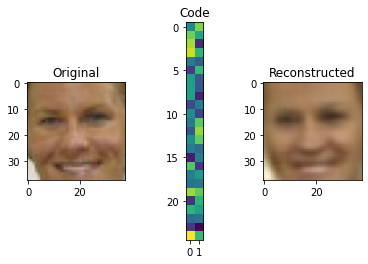

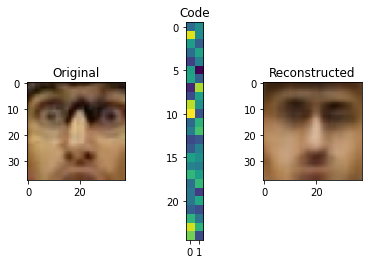

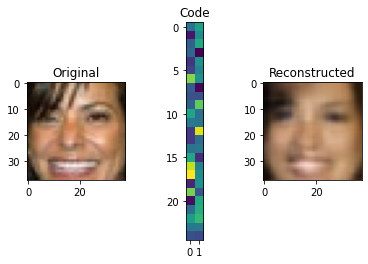

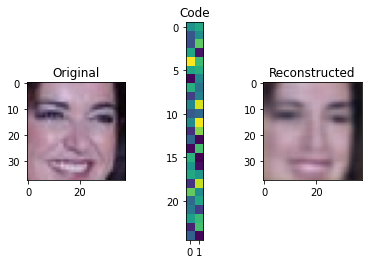

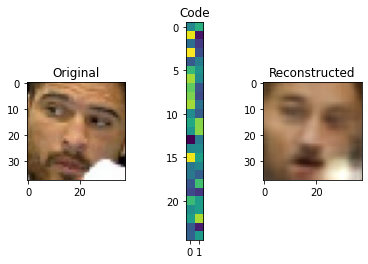

In [38]:
test_model(aenc_v2)

In [39]:
torch.save(aenc_v2.state_dict(), 'weights_v2.pth')

__Tips:__ If you keep getting "Compression to lossy" error, there's a few things you might try:

* Make sure it converged. Some architectures need way more than 32 epochs to converge. They may fluctuate a lot, but eventually they're going to get good enough to pass. You may train your network for as long as you want.

* Complexity. If you already have, like, 152 layers and still not passing threshold, you may wish to start from something simpler instead and go in small incremental steps.

* Architecture. You can use any combination of layers (including convolutions, normalization, etc) as long as __encoder output only stores 50 numbers per training object__. 

A cunning learner can circumvent this last limitation by using some manual encoding strategy, but he is strongly recommended to avoid that.

## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

We'll keep your model architecture, but change the way it trains. In particular, we'll corrupt it's input data randomly before each epoch.

There are many strategies to apply noise. We'll implement two popular one: adding gaussian noise and using dropout.

In [51]:
def apply_gaussian_noise(X, sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    
    noise = torch.normal(0, sigma, size=X.shape).cpu()
        
    return X + noise

In [52]:
#noise tests
theoretical_std = (X[:100].std() ** 2 + 0.5 ** 2)**.5
our_std = apply_gaussian_noise(torch.from_numpy(X[:100]), sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(torch.from_numpy(X[:100]), sigma=0.5).mean() - torch.from_numpy(X[:100]).mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

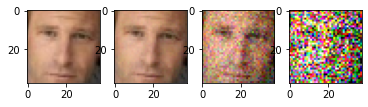

In [53]:
plt.subplot(1,4,1)
plt.imshow(X[0].transpose([1,2,0]))
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.01).data.numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.1).data.numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.5).data.numpy()[0].transpose([1,2,0]).clip(0, 1))

In [54]:
aenc = DeepAutoencoderV2(dropout=0)
train(aenc, X_train_tensor, X_test_tensor, 50, noise_function=apply_gaussian_noise)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
370it [00:08, 42.32it/s]


1, Train loss: 0.4440768317904754, Test loss: 0.10864222017871719


370it [00:07, 46.26it/s]


2, Train loss: 0.053995796648875875, Test loss: 0.013878270733249947


370it [00:08, 46.23it/s]


3, Train loss: 0.011502888035910406, Test loss: 0.00901467558983475


370it [00:08, 45.90it/s]


4, Train loss: 0.00904534572496181, Test loss: 0.00904609816992045


370it [00:08, 46.06it/s]


5, Train loss: 0.00865793116162954, Test loss: 0.008446739670085492


370it [00:08, 45.87it/s]


6, Train loss: 0.008277266946424205, Test loss: 0.008225397044817225


370it [00:08, 46.05it/s]


7, Train loss: 0.007990064225869405, Test loss: 0.00791217575262543


370it [00:08, 45.57it/s]


8, Train loss: 0.0076865515268888605, Test loss: 0.00740913915627084


370it [00:08, 45.93it/s]


9, Train loss: 0.0073912436012962685, Test loss: 0.007323028412318063


370it [00:08, 46.12it/s]


10, Train loss: 0.007150859293383068, Test loss: 0.007029294855068553


370it [00:08, 45.99it/s]


11, Train loss: 0.006987668880758944, Test loss: 0.006842762332820886


370it [00:08, 46.00it/s]


12, Train loss: 0.006856397161336365, Test loss: 0.00665992942365818


370it [00:08, 45.98it/s]


13, Train loss: 0.006716735777745973, Test loss: 0.006619838852091439


370it [00:08, 46.15it/s]


14, Train loss: 0.00664045737184581, Test loss: 0.006349076351278556


370it [00:08, 45.84it/s]


15, Train loss: 0.006536734626906059, Test loss: 0.006308386457903146


370it [00:08, 45.87it/s]


16, Train loss: 0.006398447254143826, Test loss: 0.006290714813077036


370it [00:08, 46.25it/s]


17, Train loss: 0.006361143462634547, Test loss: 0.0061441599141207745


370it [00:08, 46.05it/s]


18, Train loss: 0.006311628918207588, Test loss: 0.006209704081074584


370it [00:08, 45.99it/s]


19, Train loss: 0.006283858072608321, Test loss: 0.006163655192984808


370it [00:07, 46.36it/s]


20, Train loss: 0.006173826653236583, Test loss: 0.006023638454100457


370it [00:07, 46.31it/s]


21, Train loss: 0.006180190459548814, Test loss: 0.005879901777639724


370it [00:08, 45.96it/s]


22, Train loss: 0.00612305148994082, Test loss: 0.0058319878310607205


370it [00:08, 46.00it/s]


23, Train loss: 0.006113116431200201, Test loss: 0.005888093946127152


370it [00:08, 46.12it/s]


24, Train loss: 0.006015692032423092, Test loss: 0.005891084392772416


370it [00:08, 46.10it/s]


25, Train loss: 0.006021920357658837, Test loss: 0.0057477706691530335


370it [00:08, 45.75it/s]


26, Train loss: 0.005984569349507325, Test loss: 0.0057535011643118725


370it [00:08, 45.97it/s]


27, Train loss: 0.0059515833202713605, Test loss: 0.0057711495238790085


370it [00:08, 46.00it/s]


28, Train loss: 0.005910526755241607, Test loss: 0.005636437511162237


370it [00:08, 45.79it/s]


29, Train loss: 0.005881812796654191, Test loss: 0.00583218449178159


370it [00:08, 45.85it/s]


30, Train loss: 0.005832203317490004, Test loss: 0.005653540483972388


370it [00:08, 45.98it/s]


31, Train loss: 0.005855785595386539, Test loss: 0.005696983976898372


370it [00:08, 46.12it/s]


32, Train loss: 0.005844892181184284, Test loss: 0.005640225153502225


370it [00:08, 46.14it/s]


33, Train loss: 0.0057869964786143695, Test loss: 0.005551718140182402


370it [00:08, 45.99it/s]


34, Train loss: 0.0057979173298471805, Test loss: 0.005603441474667891


370it [00:08, 45.95it/s]


35, Train loss: 0.005777686687615145, Test loss: 0.005491396723984358


370it [00:08, 45.04it/s]


36, Train loss: 0.005737972173937896, Test loss: 0.0054897792456007856


370it [00:08, 45.84it/s]


37, Train loss: 0.005712948516288313, Test loss: 0.0054668885068293056


370it [00:08, 45.69it/s]


38, Train loss: 0.005734500732524379, Test loss: 0.005500978071787938


370it [00:08, 45.76it/s]


39, Train loss: 0.005686015047699883, Test loss: 0.005512595720827905


370it [00:08, 45.58it/s]


40, Train loss: 0.0056594780725723395, Test loss: 0.005459039973200838


370it [00:08, 45.63it/s]


41, Train loss: 0.005648598714045973, Test loss: 0.005453810252705733


370it [00:08, 45.90it/s]


42, Train loss: 0.0056661794817069846, Test loss: 0.005594124933101109


370it [00:08, 45.68it/s]


43, Train loss: 0.005676749571865983, Test loss: 0.005428996144994786


370it [00:08, 45.73it/s]


44, Train loss: 0.0055904566705528, Test loss: 0.005484035954737593


370it [00:08, 45.46it/s]


45, Train loss: 0.005624386382775051, Test loss: 0.005507036932231408


370it [00:08, 45.85it/s]


46, Train loss: 0.005593210227038756, Test loss: 0.0054444099983964895


370it [00:08, 45.59it/s]


47, Train loss: 0.005593561787374591, Test loss: 0.005404701446090792


370it [00:08, 45.65it/s]


48, Train loss: 0.005554748656586063, Test loss: 0.005419231199483812


370it [00:08, 45.70it/s]


49, Train loss: 0.005603467630455895, Test loss: 0.0054505143403313725


370it [00:08, 45.76it/s]


50, Train loss: 0.005584109915219161, Test loss: 0.005367750384118811


__Note:__ if it hasn't yet converged, increase the number of iterations.

__Bonus:__ replace gaussian noise with masking random rectangles on image.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Final MSE: 0.005471330998052966


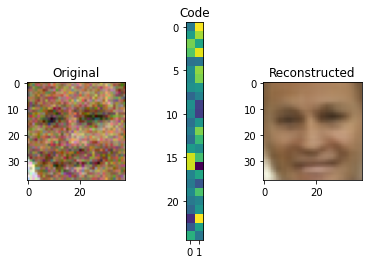

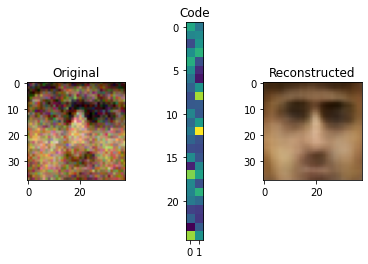

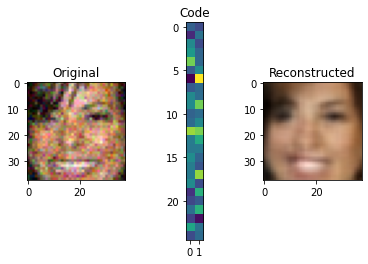

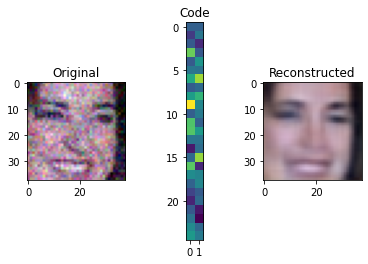

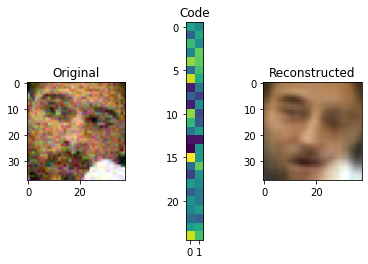

In [57]:
dataloader_test = DataLoader(X_test_tensor,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=num_workers,
                        generator=torch.Generator(device=device))
    
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch_noised = apply_gaussian_noise(batch).to(device=device)
    scores.append(aenc.batch_loss(batch_noised, batch.cuda(device = device)).data.cpu().numpy())
    encoder_out = aenc.enc(batch_noised)
reconstruction_mse  = np.mean(scores)

print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = apply_gaussian_noise(X_test_tensor[i])
    visualize(img,aenc)

In [56]:
torch.save(aenc.state_dict(), 'weights_v2_noise.pth')

### Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see it in action.

First thing we can do is image retrieval aka image search. We we give it an image and find similar images in latent space. 

To speed up retrieval process, we shall use Locality-Sensitive Hashing on top of encoded vectors. We'll use scikit-learn's implementation for simplicity. In practical scenario, you may want to use [specialized libraries](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) for better performance and customization.

In [63]:
#encodes batch of images into a codes

codes = aenc.enc(X_train_tensor.to(device))

In [64]:
assert codes.shape[0] == X_train_tensor.shape[0]

In [71]:
# from sklearn.neighbors import LSHForest
# lshf = LSHForest(n_estimators=50).fit(codes.detach().cpu().numpy())

from sklearn.neighbors import NearestNeighbors
nn_clf = NearestNeighbors(metric="euclidean")
nn_clf.fit(codes.detach().cpu())

NearestNeighbors(metric='euclidean')

In [72]:
images = torch.from_numpy(X_train).type(torch.DoubleTensor)

In [85]:
def get_similar(image, n_neighbors=5):
    assert len(image.shape) == 3, "image must be [batch, 3, height, width]"

    code = aenc.enc(image[None, ...].cuda(device)).detach().cpu().numpy()
    
    (distances,), (idx,) = nn_clf.kneighbors(code, n_neighbors=n_neighbors)
    return distances, images[idx]

In [86]:
def show_similar(image):
    distances, neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

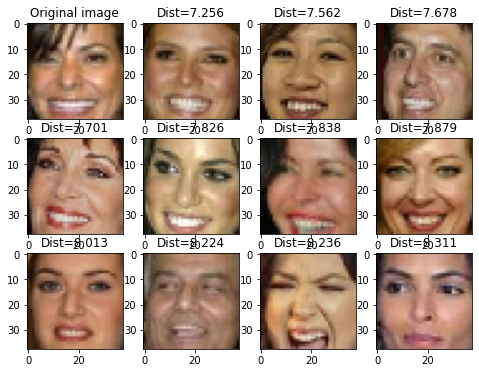

In [87]:
#smiles
show_similar(X_test_tensor[2])

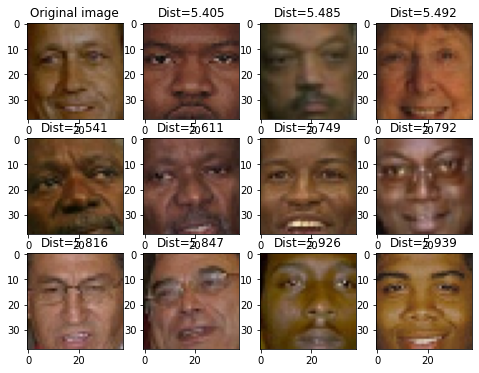

In [88]:
#ethnicity
show_similar(X_test_tensor[500])

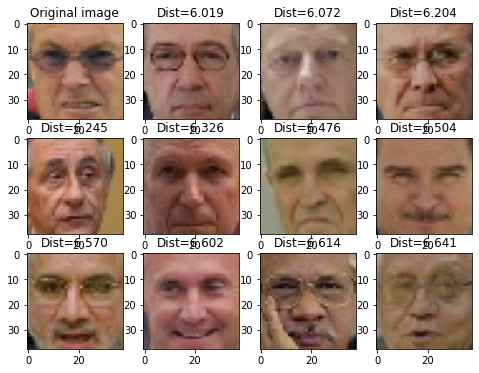

In [89]:
#glasses
show_similar(X_test_tensor[66])

## Bonus: cheap image morphing


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


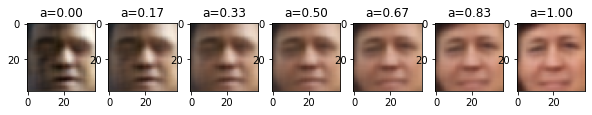

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


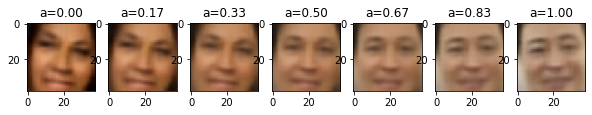

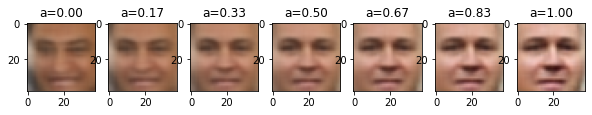

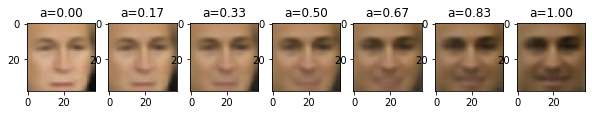

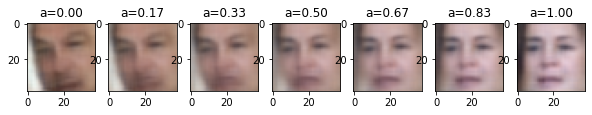

In [112]:
for _ in range(5):
    image1, image2 = X_test_tensor[np.random.randint(0, len(X_test),size=2)]

    image_pair = np.stack([image1, image2])
    
    code1, code2 = aenc.enc(torch.from_numpy(image_pair).to(device))

    plt.figure(figsize=[10, 4])
    for i, a in enumerate(np.linspace(0, 1, num=7)):
        output_code = code1 * (1 - a) + code2 * a
        output_image = aenc.dec(output_code)[0]
        plt.subplot(1, 7, i+1)
        plt.imshow(output_image.permute(1, 2, 0).cpu().detach().numpy())
        plt.title("a=%.2f"%a)
        
    plt.show()

Of course there's a lot more you can do with autoencoders.
If you want to generate images from scratch, however, you're better off using generative adversarial networks.